# Final Project: Tasten Klassifizierung anhand des Geräuchs mittels Keras und Tensorflow 
### Universität: Hochschule der Medien Stuttgart
**Fakultät für Berufsbegleitende Studiengänge**

**Studiengang:** Data Science

**Abgabedatum:**  01.03.2024

**Professor:** Dr. Christian Becker-Asano

**Student:** Raghid Allaham

## idea and approaches

## research question

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv1D,MaxPool1D, AveragePooling1D
from tensorflow.keras.optimizers import SGD, Adam
import pandas as pd
import seaborn as sns
from imutils import paths
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import wandb
from sklearn.metrics import confusion_matrix, classification_report
import librosa

In [121]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [122]:
# Laden einer .wav-Datei
audio_path = './Data/lernwelt/1_2024-01-21_12-11-24.wav'
audio, sr = librosa.load(audio_path, sr=None)


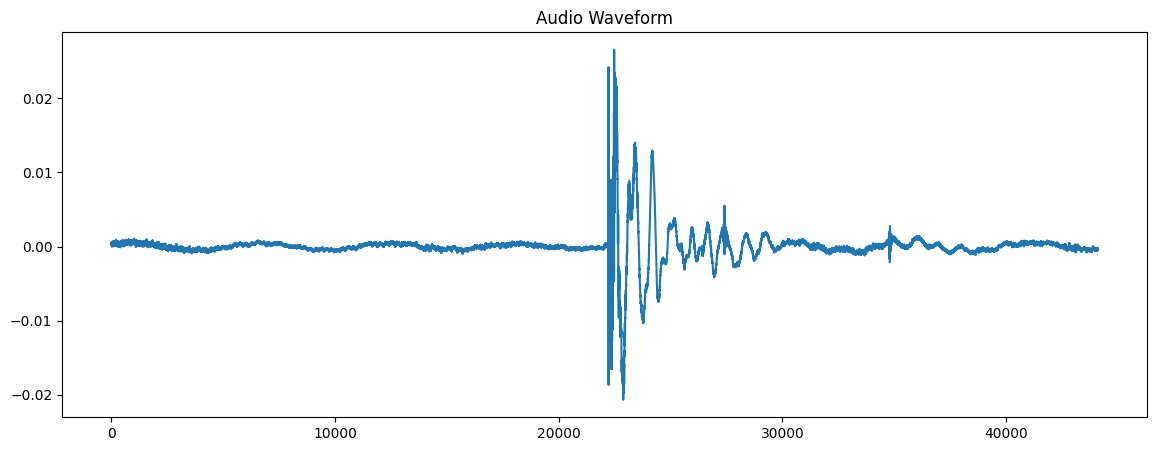

In [123]:
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.title('Audio Waveform')
plt.show()

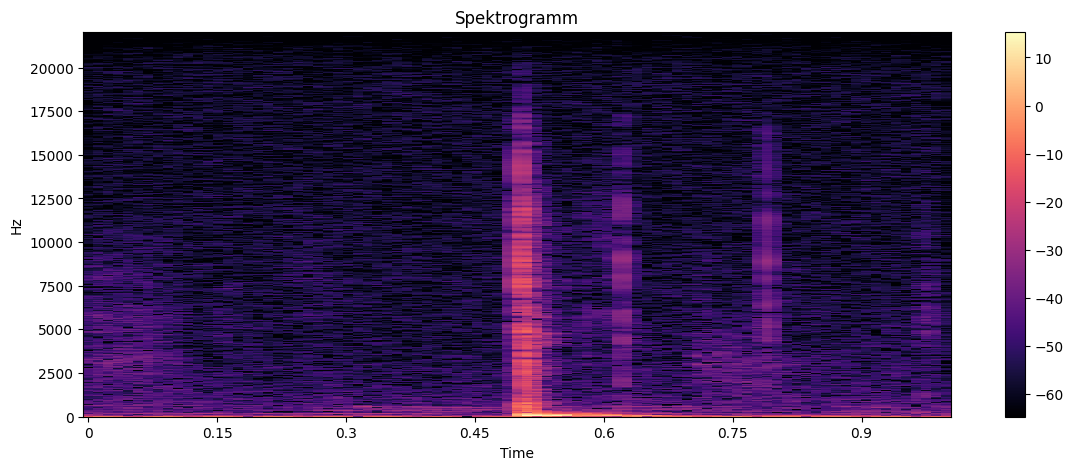

In [124]:
import librosa.display
import numpy as np

X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Spektrogramm')
plt.show()


In [178]:
import os


base_path = './classes_lw'  # Basispfad zu Ihren Audiodateien
classes = os.listdir(base_path)  # Liste der Klassennamen

data = []  # Liste zum Speichern der Audiodaten
labels = []  # Liste zum Speichern der zugehörigen Labels

for class_label in classes:
    class_path = os.path.join(base_path, class_label)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                audio, sr = librosa.load(file_path, sr=None)  # Laden der Audiodatei
                audio = audio / np.max(np.abs(audio))  # Normalisierung
                data.append(audio)
                labels.append(class_label)


In [179]:
print(type(data))

<class 'list'>


In [180]:
print(f"Data matrix shape: {len(data)} x {len(data[0])}")

Data matrix shape: 1055 x 44100


In [181]:
classes

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'enter', 'esc', 'shift', 'space']

In [182]:
# Check if all data has the same legnth
leng_data= len(data[0])
for i in data:
    if len(i)!=leng_data:
        print(i)
    

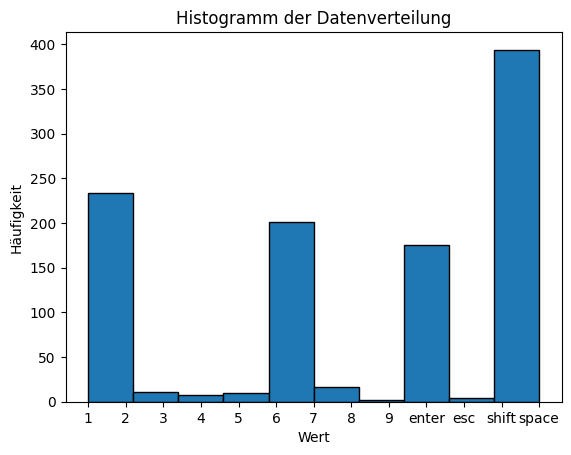

In [183]:
plt.hist(labels, edgecolor='black')
plt.title('Histogramm der Datenverteilung')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

we also need to filter for the relevant classes: ['shift','space','enter','1','6']

In [184]:
relevant_classes = ['1','6','shift','space','enter']

data = []  # Liste zum Speichern der Audiodaten
labels = []  # Liste zum Speichern der zugehörigen Labels

for class_label in relevant_classes:
    class_path = os.path.join(base_path, class_label)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                audio, sr = librosa.load(file_path, sr=None)  # Laden der Audiodatei
                audio = audio / np.max(np.abs(audio))  # Normalisierung
                data.append(audio)
                labels.append(class_label)


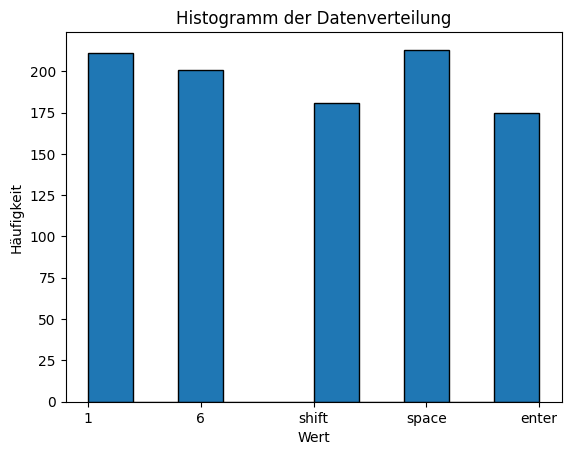

In [185]:
plt.hist(labels, edgecolor='black')
plt.title('Histogramm der Datenverteilung')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

Die Basline welche geschlagen werden muss um zu beweisen, dass eine erkennung möglich ist 20 % classifcation Rate.

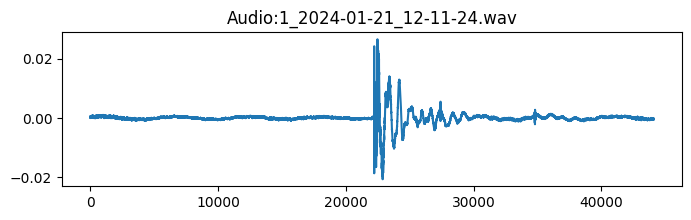

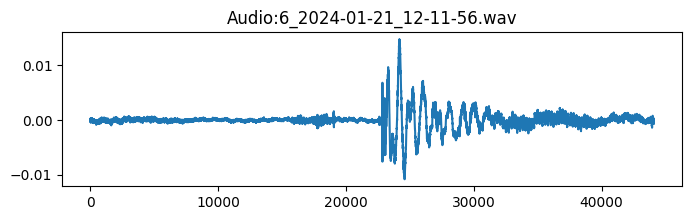

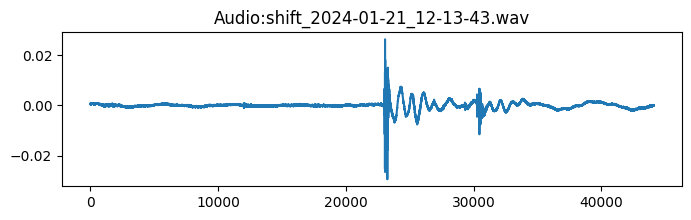

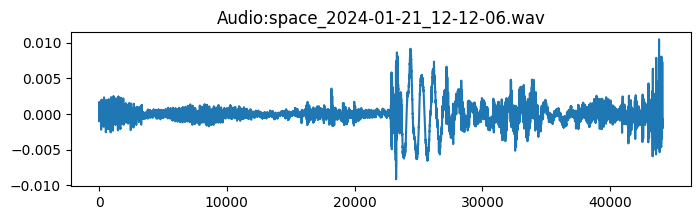

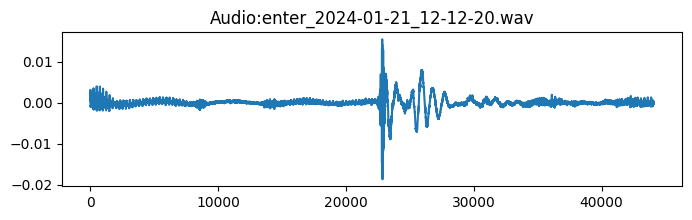

In [186]:
for cli, i in enumerate(relevant_classes):
    subfolder = "./classes_lw/" + i
    wav = os.listdir(subfolder)[0]
    audio, sr = librosa.load(subfolder + "/" + wav, sr=None)
    plt.figure(figsize=(8, 2))
    plt.plot(audio)
    plt.title('Audio:' + wav)
plt.show()
    


### Define Region of interest:

From the picture above we can see that we are mostily intrested in the erea between 20000 and 30000 this why we will cut the first and last 10000 points away.

In [187]:
trimmed_data = [array[15000:-8000] for array in data]
print(len(trimmed_data),len(trimmed_data[0]) )

981 21100


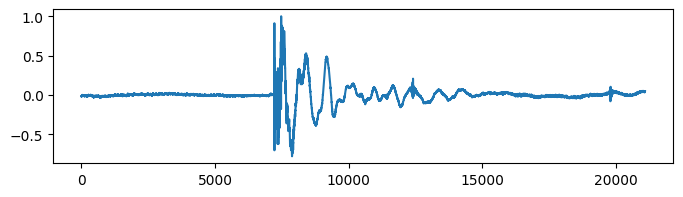

In [188]:
plt.figure(figsize=(8, 2))
plt.plot(trimmed_data[0])
plt.show()

## Data Peperation:

In the previous trainings a Validation Accuracity of 65 % has been reached which is already very good. In the same time a Training Accourcty of 90 % has also been reached. Which is an indication for overfitting. To prevent overfitting, either a more samples are needed ( a bigger dataset) or we can augoment the available date with some noice pich and shifting.

Bild Hinzufügen []

In [189]:
from audiomentations import Compose, AddGaussianNoise, PitchShift, Shift

# Erstellen Sie eine Augmentations-Pipeline
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.010, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.3, max_shift=0.3, p=0.5),
])

augmented_samples_list = []

for sample in trimmed_data:
    # Stellen Sie sicher, dass jedes Sample das richtige Format hat
    if sample.dtype != np.float32:
        sample = sample.astype(np.float32)
    
    # Wenden Sie die Augmentation auf jedes Sample einzeln an
    augmented_sample = augment(samples=sample, sample_rate=21100)
    augmented_samples_list.append(augmented_sample)

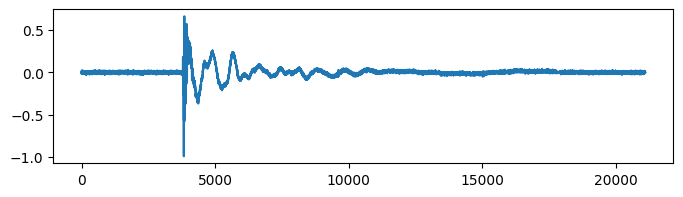

In [190]:
plt.figure(figsize=(8, 2))
plt.plot(augmented_samples_list[1])
plt.show()

In [191]:
training_data = trimmed_data + augmented_samples_list
if len(labels) != len(training_data):
    labels = labels + labels
len(labels)

1962

In [192]:
#training_data = augmented_samples_list
print(len(training_data),len(training_data[0]) )

1962 21100


In [193]:
# start a new wandb run to track this script
dense = 512
filter1 = 32
filter3 = 64
filter2 = 128
filter4 = 256
kern1 = 6
kern2 = 6
learning_rate = 0.005
epochs = 32
batch = 16
wandb.init(
    # set the wandb project where this run will be logged
    project="AAI-Final-Projekt_3",
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "hidden-CNN-Layer": 4,
    "dropout":4,
    "filter1":filter1,
    "filter2":filter2,
    "filter3":filter3,
    "filter4":filter4,
    "Kernel1":kern1,
    "Kernel2":kern2,
    "dropout-values:": 0.3,
    "dataset": "self_made",
    "Activation_function": "relu",
    "patience":"9",
    "epochs": epochs,
    "optimizer": "SGD",
    "loss_function": "categorical_crossentropy",
    "batch_size":batch,
    "test_size":0.3,
    "Dense":dense,
    }
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [209]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [210]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = np.array(training_data) 
y = to_categorical(encoded_labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [211]:
from tensorflow.keras.layers import Conv1D, MaxPool1D

model = Sequential()
model.add(Conv1D(filters=filter1, kernel_size=kern1, input_shape=(len(trimmed_data[0]), 1), activation='relu'))
model.add(AveragePooling1D(pool_size=8))
model.add(Dropout(0.2))
model.add(Conv1D(filters=filter2, kernel_size=kern1, activation='relu',padding='same'))
model.add(AveragePooling1D(pool_size=12))
model.add(Conv1D(filters=filter3, kernel_size=kern2, activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(Conv1D(filters=filter4, kernel_size=kern2, activation='relu',padding='same'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(dense, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 21095, 32)         224       
                                                                 
 average_pooling1d_14 (Aver  (None, 2636, 32)          0         
 agePooling1D)                                                   
                                                                 
 dropout_28 (Dropout)        (None, 2636, 32)          0         
                                                                 
 conv1d_29 (Conv1D)          (None, 2636, 128)         24704     
                                                                 
 average_pooling1d_15 (Aver  (None, 219, 128)          0         
 agePooling1D)                                                   
                                                                 
 conv1d_30 (Conv1D)          (None, 219, 64)          

In [212]:
lrate = learning_rate
decay = lrate/epochs
sgd = SGD(learning_rate=lrate, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

In [213]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=12, mode='min', restore_best_weights=True)

In [214]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch, callbacks=[early_stopping])
model.save("./Modell/audio_classifyer_light_2")

Epoch 1/32


86/86 [==============================] - 6s 62ms/step - loss: 1.5933 - accuracy: 0.2294 - val_loss: 1.5737 - val_accuracy: 0.2360
Epoch 2/32
86/86 [==============================] - 5s 56ms/step - loss: 1.5339 - accuracy: 0.3154 - val_loss: 1.5067 - val_accuracy: 0.3243
Epoch 3/32
86/86 [==============================] - 5s 57ms/step - loss: 1.4750 - accuracy: 0.3598 - val_loss: 1.4235 - val_accuracy: 0.4143
Epoch 4/32
86/86 [==============================] - 5s 57ms/step - loss: 1.4141 - accuracy: 0.3955 - val_loss: 1.4003 - val_accuracy: 0.3854
Epoch 5/32
86/86 [==============================] - 5s 57ms/step - loss: 1.3958 - accuracy: 0.4020 - val_loss: 1.3533 - val_accuracy: 0.4228
Epoch 6/32
86/86 [==============================] - 5s 57ms/step - loss: 1.3223 - accuracy: 0.4319 - val_loss: 1.3153 - val_accuracy: 0.4482
Epoch 7/32
86/86 [==============================] - 5s 57ms/step - loss: 1.3007 - accuracy: 0.4603 - val_loss: 1.2933 - val_accuracy: 0.4550
Epoch 8/32
86/86 [======

INFO:tensorflow:Assets written to: ./Modell/audio_classifyer_light_2/assets


In [215]:
for tl,vl in zip(history.history['loss'],history.history['val_loss']):
    wandb.log({"loss_train": tl, "loss_valid": vl})#

for ta,va in zip(history.history['accuracy'],history.history['val_accuracy']):
    wandb.log({"accuracy": ta, "val_accuracy": va})

Error: You must call wandb.init() before wandb.log()

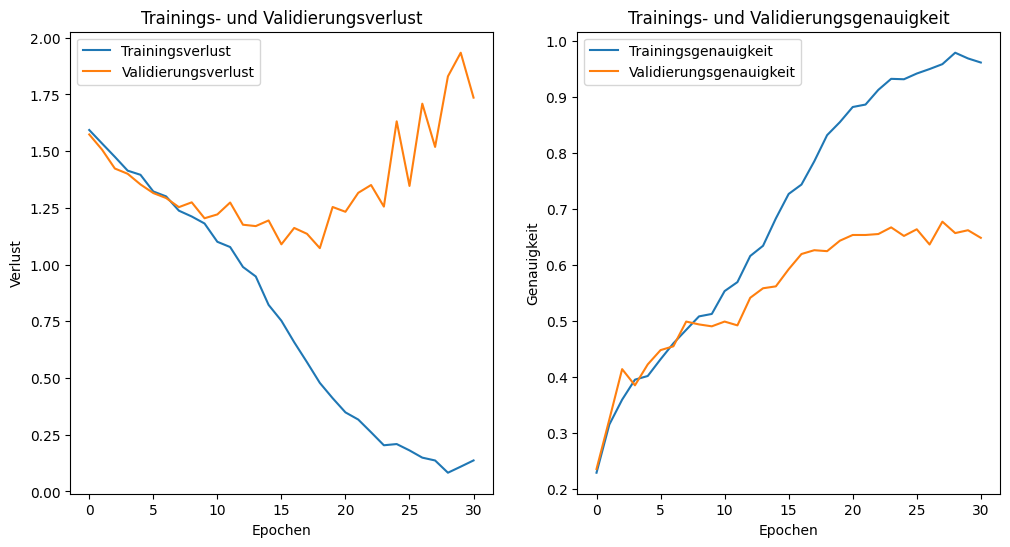

In [216]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()

# Plot für Trainings- und Validierungsgenauigkeit
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()

plt.show()

In [217]:
predictions = model.predict(X_val)

19/19 [==============================] - 1s 15ms/step


In [218]:
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_val, axis=1)

In [219]:
cm = confusion_matrix(actual_classes, predicted_classes)
cm

array([[75,  9,  5,  9, 12],
       [21, 85,  9,  4, 18],
       [12,  4, 60, 16,  7],
       [17,  4, 16, 70, 11],
       [12, 13,  7, 15, 78]])

In [220]:
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(8, 6)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() 

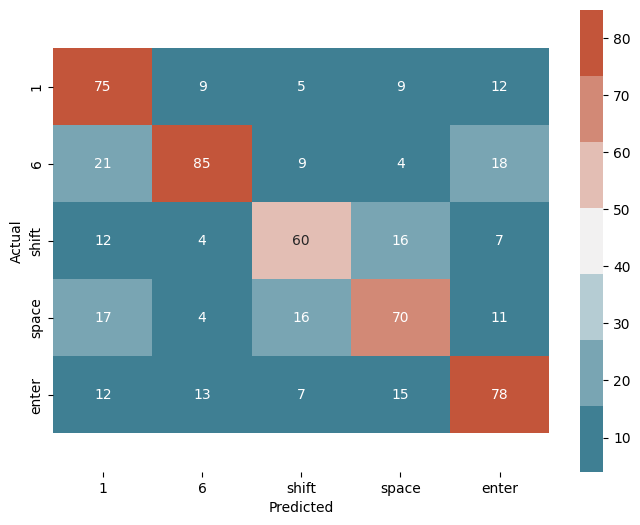

In [221]:
plot_cm(actual_classes, predicted_classes, relevant_classes)

In [222]:
wandb.finish()

## Second Model Adam

In [ ]:
BREAk

NameError: name 'BREAk' is not defined

In [ ]:
# start a new wandb run to track this script
dense = 1024
filter1 = 64
filter3 = 32
filter2 = 32
filter4 = 16
kern1 = 12
kern2 = 6
kern3 = 6
kern4 = 4
learning_rate = 0.01
epochs = 32
batch = 16
wandb.init(
    # set the wandb project where this run will be logged
    project="AAI-Final-Projekt",
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "hidden-CNN-Layer": 3,
    "dropout":3,
    "maxpool":1,
    "filter1":filter1,
    "filter2":filter2,
    "filter3":filter3,
    "filter4":filter4,
    "Kern1":kern1,
    "Kern2":kern2,
    "Kern3":kern3,
    "Kern4":kern4,
    "dropout-values:": 0.3,
    "dataset": "self_made",
    "Activation_function": "relu",
    "patience":"9",
    "epochs": epochs,
    "optimizer": "SGD",
    "loss_function": "categorical_crossentropy",
    "batch_size":batch,
    "test_size":0.3,
    "Dense":dense,
    }
)

In [ ]:
model_2 = Sequential()
model_2.add(Conv1D(filters=filter1, kernel_size=kern1, input_shape=(len(trimmed_data[0]), 1), activation='relu'))
#model_2.add(MaxPool1D(pool_size=4))
model_2.add(Dropout(0.2))
model_2.add(Conv1D(filters=filter2, kernel_size=kern2, activation='relu',padding='same'))
model_2.add(AveragePooling1D(pool_size=3))
model_2.add(Conv1D(filters=filter3, kernel_size=kern3, activation='relu',padding='same'))
model_2.add(Dropout(0.3))
model_2.add(Conv1D(filters=filter4, kernel_size=4, activation='relu',padding='same'))
model_2.add(Flatten())
model_2.add(Dropout(0.2))
model_2.add(Dense(dense, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(5, activation='softmax'))
model_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 34089, 64)         832       
                                                                 
 dropout_49 (Dropout)        (None, 34089, 64)         0         
                                                                 
 conv1d_53 (Conv1D)          (None, 34089, 32)         12320     
                                                                 
 average_pooling1d_15 (Aver  (None, 11363, 32)         0         
 agePooling1D)                                                   
                                                                 
 conv1d_54 (Conv1D)          (None, 11363, 32)         6176      
                                                                 
 dropout_50 (Dropout)        (None, 11363, 32)         0         
                                                     

In [ ]:
epochs = epochs
learning_rate
decay = learning_rate/epochs
adam = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=decay)
model_2.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])

In [ ]:
history_2=model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch, callbacks=[early_stopping])
model_2.save("./Modell/audio_classifyer_adam")

Epoch 1/32


43/43 [==============================] - 14s 291ms/step - loss: 4.4200 - accuracy: 0.2070 - val_loss: 1.6222 - val_accuracy: 0.1966
Epoch 2/32
43/43 [==============================] - 12s 276ms/step - loss: 1.6126 - accuracy: 0.2026 - val_loss: 1.6150 - val_accuracy: 0.1966
Epoch 3/32
43/43 [==============================] - 12s 274ms/step - loss: 1.6085 - accuracy: 0.2230 - val_loss: 1.6127 - val_accuracy: 0.1932
Epoch 4/32
43/43 [==============================] - 12s 277ms/step - loss: 1.6063 - accuracy: 0.2259 - val_loss: 1.6133 - val_accuracy: 0.1932
Epoch 5/32
43/43 [==============================] - 12s 277ms/step - loss: 1.6069 - accuracy: 0.2230 - val_loss: 1.6161 - val_accuracy: 0.1932
Epoch 6/32
43/43 [==============================] - 12s 271ms/step - loss: 1.6104 - accuracy: 0.2055 - val_loss: 1.6180 - val_accuracy: 0.1966
Epoch 7/32
43/43 [==============================] - 12s 272ms/step - loss: 1.6080 - accuracy: 0.2172 - val_loss: 1.6166 - val_accuracy: 0.1966
Epoch 8/32

INFO:tensorflow:Assets written to: ./Modell/audio_classifyer_adam/assets


In [ ]:
for tl,vl in zip(history_2.history['loss'],history_2.history['val_loss']):
    wandb.log({"loss_train": tl, "loss_valid": vl})#

for ta,va in zip(history_2.history['accuracy'],history_2.history['val_accuracy']):
    wandb.log({"accuracy": ta, "val_accuracy": va})

In [ ]:
loss,acc = model_2.evaluate(X_train, y_train, verbose=0)
print("Accuracy on Test Data : %.2f%%" % (acc*100))

Accuracy on Test Data : 22.59%


In [ ]:
loss,acc = model_2.evaluate(X_val, y_val, verbose=0)
print("Accuracy on Test Data : %.2f%%" % (acc*100))

Accuracy on Test Data : 19.66%


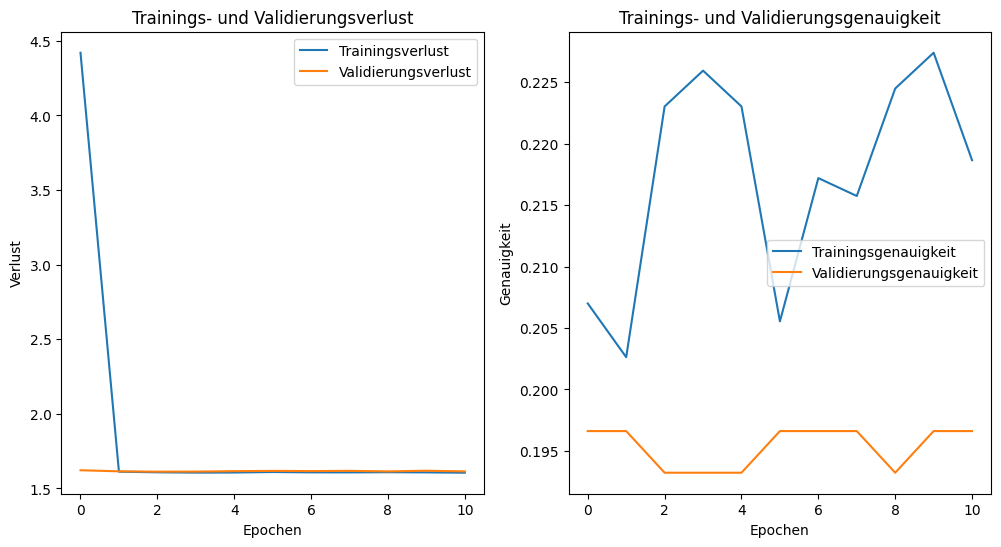

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Trainingsverlust')
plt.plot(history_2.history['val_loss'], label='Validierungsverlust')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()

# Plot für Trainings- und Validierungsgenauigkeit
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history_2.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()

plt.show()

In [ ]:
predictions = model_2.predict(X_val)

 2/10 [=====>........................] - ETA: 0s

10/10 [==============================] - 1s 64ms/step


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_val, axis=1)

In [ ]:
cm = confusion_matrix(actual_classes, predicted_classes)
cm

array([[ 0,  0,  0,  0, 57],
       [ 0,  0,  0,  0, 69],
       [ 0,  0,  0,  0, 50],
       [ 0,  0,  0,  0, 61],
       [ 0,  0,  0,  0, 58]])

In [ ]:
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(8, 6)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() 

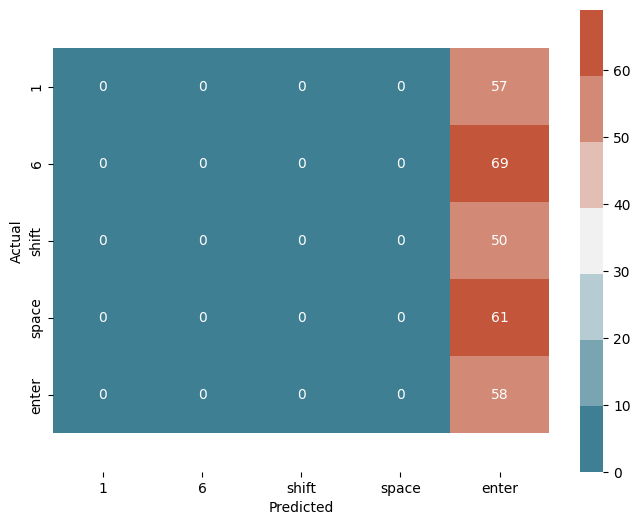

In [ ]:
plot_cm(actual_classes, predicted_classes, relevant_classes)

In [ ]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█▇█▇███
loss_train,██▇▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▂▃▂▂▂▂▁▂▁▂▁▁▁
loss_valid,▇▆▅▄▄▄▄▃▃▃▂▄▃▂▂▄▅▃▁▃▃▄▇▁█▇▅▃▃▄▅
val_accuracy,▁▃▅▄▄▅▄▆▅▅▆▆▆▇▇▇▆▇█▇▆▇▇█▇▇▇▇███
accuracy,0.89359
loss_train,0.28814
loss_valid,1.44249
val_accuracy,0.65085
